# Imports and setup

In [1]:
########## 1. Import required libraries ##########

import pandas as pd
import numpy as np
import re
import math
import pandas as pd
import matplotlib.pyplot as plt

# Text and feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Evaluation and tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_curve, auc, classification_report)

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Text cleaning & stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chibu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Step 1: Preprocess and Save Processed Data to CSV 

##### Functions to preprocess data

In [2]:
########## 2. Define text preprocessing methods ##########

def remove_html(text):
    """Remove HTML tags using a regex."""
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    """Remove emojis using a regex pattern."""
    emoji_pattern = re.compile("[" u"\U0001F600-\U0001F64F"  
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002702-\U000027B0"  
                               u"\U000024C2-\U0001F251" "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {}  # Define your custom stopwords here
    stop_words.update(custom_stopwords)
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

def clean_str(string):
    """
    Clean text by removing non-alphanumeric characters,
    and convert it to lowercase.
    """
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

def check_data_leakage(X_train, X_test):
    train_set = set(map(tuple, X_train))
    test_set = set(map(tuple, X_test))

    leaked_samples = train_set.intersection(test_set)
    print("\n🔍 Checking Data Leakage...")
    print(f"⚠️ {len(leaked_samples)} samples from test data are also in training data.")

    if len(leaked_samples) > 0:
        print("❌ Data Leakage Detected! Test data should not exist in training set.")
    else:
        print("✅ No Data Leakage Detected.")

##COMAPRES TEST ACCURACY TO TRAIN ACCURACY
def check_overfitting(model, X_train, y_train, X_test, y_test):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)
    
    print("\n🔍 Checking Overfitting...")
    print(f"📊 Training Accuracy: {train_acc:.4f}")
    print(f"📊 Test Accuracy: {test_acc:.4f}")

    if train_acc > test_acc + 0.10:
        print("❌ Possible Overfitting: Model performs much better on training data.")
    else:
        print("✅ No significant overfitting detected.")

# Line Chart (Trend over Repeats)
def plot_metric_trends(csv_path):
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(8, 4))
    metric_columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']

    for metric in metric_columns:
        plt.plot(df['Repeat'], df[metric], marker='o', label=metric)

    # Chart styling
    plt.xlabel("Repeat")
    plt.ylabel("Score")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(metric_columns), frameon=False)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

##### Download and read data, save to csv files for repeatable use

In [3]:
########## 3. Download & read data ##########
project = 'pytorch'
text_col = 'Title+Body'


In [5]:
path = f'C:/Users/chibu/Documents/ISE-solution-main/Coursework/datasets/{project}.csv'

data = pd.read_csv(path).fillna('')
data['Title+Body'] = data.apply(lambda row: row['Title'] + '. ' + row['Body'] if pd.notna(row['Body']) else row['Title'], axis=1)
#text_col = 'Title+Body'

data[text_col] = data[text_col].apply(remove_html)
data[text_col] = data[text_col].apply(remove_emoji)
data[text_col] = data[text_col].apply(remove_stopwords)
data[text_col] = data[text_col].apply(clean_str)

data.to_csv(f'{project}_processed_data.csv', index=False)


##### Load and check datasets in Title+Body Files

In [4]:
baseline_path = 'C:/Users/chibu/Documents/ISE-solution-main/Coursework/trial2'

df = pd.read_csv(f'{project}_processed_data.csv')
df.head()

,Unnamed: 0,Repository,Number,State,Title,Body,Labels,Comments,Codes,Commands,class,related,Title+Body
0,0,pytorch,15872,closed,GPU memory usage is very high at the beginning...,## 🐛 Bug\r\n\r\nAt the beginning of the traini...,NaN,['This is because you are using cudnn.benchmar...,['\r\nCollecting environment information...\r\...,['334'],1,0,gpu memory usage high beginning training.. bug...
1,1,pytorch,8710,closed,Incorrect calculation for torch.nn.MSELoss,## Issue description\r\ntorch.nn.MSELoss seems...,NaN,['Actually it is `0.01` and `0.00983`. But sti...,"['\r\nIn [10]: preds = torch.ones(5, 68, 64, 6...",[],1,1,incorrect calculation torch.nn.mseloss. issue ...
2,2,pytorch,13843,closed,Possible CPU-side memory leak even when fittin...,## 🐛 Bug\r\n\r\nA possible CPU-side memory lea...,todo,['This is probably the cudnn memory leak at ht...,"[""\r\ndevice = 'cuda'\r\nmodel = SkipThought(l...","['conda', 'pip']",1,1,possible cpu side memory leak even fitting gpu...
3,3,pytorch,537,closed,Initial call to .cuda() very slow with Titan X,The first call to .cuda() takes more than one ...,high priority,['you installed with Conda.\r\nYour Titan-X is...,['\r\nimport torch\r\nfrom datetime import dat...,[],1,1,initial call .cuda( ) slow titan x. first call...
4,4,pytorch,7714,closed,Very slow for gradient penalty!,Gradient penalty (GP) here means we minimize L...,NaN,['Gradient penalty requires computing second o...,['\r\nwithout : 0.065s\r\nwith GP: 0.330s\r\n'...,[],1,0,slow gradient penalty!. gradient penalty (gp )...


### Step 2: Configure parameters and start training

##### Set values, params and load csv files

In [7]:
# Number of repeated experiments
REPEAT = 30

# Output CSV file name
results_dir = "C:/Users/chibu/Documents/ISE-solution-main/Coursework/trial2/results"
out_csv_name = f"{results_dir}/{project}_Results.csv"

# Convert and save metrics for all models
def save_model_metrics(metrics_list, filename):
    df = pd.DataFrame(metrics_list)
    df.to_csv(f"{results_dir}/{filename}", index=False)
    print(f"Saved: {filename}")
    print(df.mean(numeric_only=True))
    print("\n")

# Hyperparameter grid for Naive Bayes
params = {'var_smoothing': np.logspace(-12, 0, 13)}

# Lists to store metrics across repeated runs
accuracies, precisions, recalls, f1_scores, auc_values = [], [], [], [], []

##### Perform Testing on Baseline code from Lab 1

In [8]:
nb_metrics = []
# Load dataset for this iteration
data = pd.read_csv(f'{project}_processed_data.csv')
X = data[text_col]
y = data['class']

for repeated_time in range(REPEAT):
    

    # Train-test split (70/30)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # Apply TF-IDF vectorization
    tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf = tfidf.fit_transform(X_train).toarray()
    X_test_tfidf = tfidf.transform(X_test).toarray()

    # Train and Evaluate Naive Bayes with Cross-Validation
    nb_clf = GaussianNB()
    grid = GridSearchCV(nb_clf, params, cv=5, scoring='roc_auc')
    grid.fit(X_train_tfidf, y_train)
    best_nb = grid.best_estimator_
    y_pred_nb = best_nb.predict(X_test_tfidf)
    
    nb_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test, y_pred_nb),
        "Precision": precision_score(y_test, y_pred_nb, average='macro'),
        "Recall": recall_score(y_test, y_pred_nb, average='macro'),
        "F1": f1_score(y_test, y_pred_nb, average='macro'),
        "AUC": auc(*roc_curve(y_test, y_pred_nb, pos_label=1)[:2])
    })

    save_model_metrics(nb_metrics, f'{project}_NaiveBayes_Metrics.csv')

Saved: pytorch_NaiveBayes_Metrics.csv
Repeat       0.000000
Accuracy     0.676991
Precision    0.636032
Recall       0.800018
F1           0.604051
AUC          0.800018
dtype: float64


Saved: pytorch_NaiveBayes_Metrics.csv
Repeat       0.500000
Accuracy     0.672566
Precision    0.637161
Recall       0.784200
F1           0.605640
AUC          0.784200
dtype: float64


Saved: pytorch_NaiveBayes_Metrics.csv
Repeat       1.000000
Accuracy     0.650442
Precision    0.624578
Recall       0.770813
F1           0.581731
AUC          0.770813
dtype: float64


Saved: pytorch_NaiveBayes_Metrics.csv
Repeat       1.500000
Accuracy     0.647124
Precision    0.617661
Recall       0.763980
F1           0.573507
AUC          0.763980
dtype: float64


Saved: pytorch_NaiveBayes_Metrics.csv
Repeat       2.000000
Accuracy     0.651327
Precision    0.621471
Recall       0.770096
F1           0.578904
AUC          0.770096
dtype: float64


Saved: pytorch_NaiveBayes_Metrics.csv
Repeat       2.500000
Accur

##### View progressive results

In [9]:
df = pd.read_csv(f'{baseline_path}/results/{project}_NaiveBayes_Metrics.csv')
df.head() 

,Repeat,Accuracy,Precision,Recall,F1,AUC
0,0,0.676991,0.636032,0.800018,0.604051,0.800018
1,1,0.668142,0.638290,0.768382,0.607230,0.768382
2,2,0.606195,0.599412,0.744038,0.533913,0.744038
3,3,0.637168,0.596911,0.743483,0.548836,0.743483
4,4,0.668142,0.636712,0.794558,0.600490,0.794558


##### Save final results to csv file

In [10]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in nb_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in nb_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in nb_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in nb_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in nb_metrics])
}

save_model_metrics([final_metrics], f'{project}_NaiveBayes_Final_Metrics.csv')

Saved: pytorch_NaiveBayes_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.641888
Avg_Precision     0.615774
Avg_Recall        0.761836
Avg_F1            0.568303
Avg_AUC           0.761836
dtype: float64




##### Load results for baseline 

In [11]:
df = pd.read_csv(f'{baseline_path}/results/{project}_NaiveBayes_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.641888,0.615774,0.761836,0.568303,0.761836


### Examine datasets for data leakage and overfitting and class ditribution to know what to expect when it comes to validating my results based on baseline

In [12]:


#check where these variables are coming from
# For baseline Naive Bayes testing:
check_data_leakage(X_train_tfidf, X_test_tfidf)
check_overfitting(best_nb, X_train_tfidf, y_train, X_test_tfidf, y_test)

print("\nClass Distribution in Training Set:")
print(y_train.value_counts())
print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))


🔍 Checking Data Leakage...
⚠️ 1 samples from test data are also in training data.
❌ Data Leakage Detected! Test data should not exist in training set.

🔍 Checking Overfitting...
📊 Training Accuracy: 0.7129
📊 Test Accuracy: 0.6018
❌ Possible Overfitting: Model performs much better on training data.

Class Distribution in Training Set:
class
0    461
1     65
Name: count, dtype: int64

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.99      0.55      0.70       196
           1       0.25      0.97      0.39        30

    accuracy                           0.60       226
   macro avg       0.62      0.76      0.55       226
weighted avg       0.89      0.60      0.66       226



##### Line chart repeats

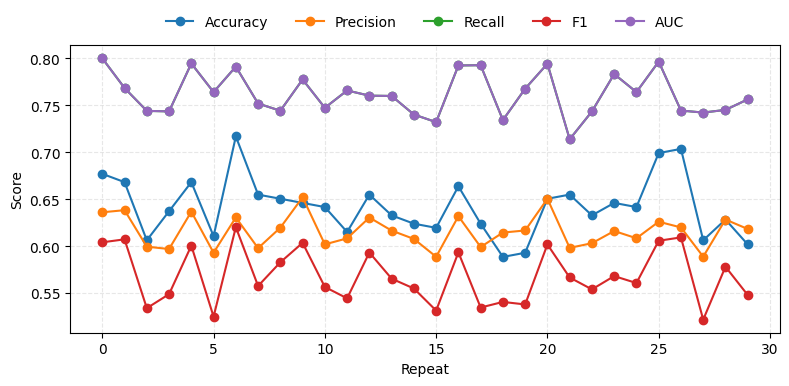

In [5]:
plot_metric_trends(f'{baseline_path}/results/{project}_NaiveBayes_Metrics.csv')

##### Perform Testing with Random Forest

In [13]:
rf_metrics = []

# Load dataset for this iteration
data_rf = pd.read_csv(f'{project}_processed_data.csv')
X_rf = data_rf[text_col]
y_rf = data_rf['class']

for repeated_time in range(REPEAT):
    
    # Train-test split (70/30)
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
        X_rf, y_rf, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # Apply TF-IDF vectorization
    tfidf_rf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_rf = tfidf_rf.fit_transform(X_train_rf).toarray()
    X_test_tfidf_rf = tfidf_rf.transform(X_test_rf).toarray()

    # Train and Evaluate Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20)
    rf_clf.fit(X_train_tfidf_rf, y_train_rf)
    y_pred_rf = rf_clf.predict(X_test_tfidf_rf)

    rf_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_rf, y_pred_rf),
        "Precision": precision_score(y_test_rf, y_pred_rf, average='macro'),
        "Recall": recall_score(y_test_rf, y_pred_rf, average='macro'),
        "F1": f1_score(y_test_rf, y_pred_rf, average='macro'),
        "AUC": auc(*roc_curve(y_test_rf, y_pred_rf, pos_label=1)[:2])
    })

    save_model_metrics(rf_metrics, f'{project}_RandomForest_Metrics.csv')


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_RandomForest_Metrics.csv
Repeat       0.000000
Accuracy     0.871681
Precision    0.435841
Recall       0.500000
F1           0.465721
AUC          0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_RandomForest_Metrics.csv
Repeat       0.500000
Accuracy     0.860619
Precision    0.430310
Recall       0.500000
F1           0.462526
AUC          0.500000
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       1.000000
Accuracy     0.870206
Precision    0.546714
Recall       0.511987
F1           0.488155
AUC          0.511987
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       1.500000
Accuracy     0.876106
Precision    0.646702
Recall       0.513990
F1           0.493690
AUC          0.513990
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_RandomForest_Metrics.csv
Repeat       2.000000
Accuracy     0.874336
Precision    0.604087
Recall       0.511192
F1           0.487843
AUC          0.511192
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       2.500000
Accuracy     0.879056
Precision    0.620899
Recall       0.516086
F1           0.498386
AUC          0.516086
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       3.000000
Accuracy     0.880531
Precision    0.667084
Recall       0.519079
F1           0.504247
AUC          0.519079
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       3.500000
Accuracy     0.883296
Precision    0.702560
Recall       0.521902
F1           0.510104
AUC          0.521902
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_RandomForest_Metrics.csv
Repeat       4.000000
Accuracy     0.880531
Precision    0.672187
Recall       0.519469
F1           0.504748
AUC          0.519469
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       4.500000
Accuracy     0.876549
Precision    0.696968
Recall       0.518873
F1           0.502557
AUC          0.518873
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       5.000000
Accuracy     0.876911
Precision    0.673810
Recall       0.516930
F1           0.499437
AUC          0.516930
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       5.500000
Accuracy     0.877950
Precision    0.696363
Recall       0.517122
F1           0.500119
AUC          0.517122
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_RandomForest_Metrics.csv
Repeat       6.000000
Accuracy     0.876106
Precision    0.675642
Recall       0.515805
F1           0.497081
AUC          0.515805
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       6.500000
Accuracy     0.876106
Precision    0.694366
Recall       0.515907
F1           0.497301
AUC          0.515907
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_RandomForest_Metrics.csv
Repeat       7.000000
Accuracy     0.875811
Precision    0.677131
Recall       0.514847
F1           0.495196
AUC          0.514847
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_RandomForest_Metrics.csv
Repeat       7.500000
Accuracy     0.876936
Precision    0.662741
Recall       0.513919
F1           0.493744
AUC          0.513919
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       8.000000
Accuracy     0.876627
Precision    0.664198
Recall       0.513965
F1           0.493983
AUC          0.513965
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       8.500000
Accuracy     0.878810
Precision    0.680497
Recall       0.515835
F1           0.497918
AUC          0.515835
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       9.000000
Accuracy     0.877969
Precision    0.693688
Recall       0.515824
F1           0.497675
AUC          0.515824
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       9.500000
Accuracy     0.877876
Precision    0.693490
Recall       0.515799
F1           0.497800
AUC          0.515799
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       10

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_RandomForest_Metrics.csv
Repeat       10.500000
Accuracy      0.876508
Precision     0.692377
Recall        0.515031
F1            0.495942
AUC           0.515031
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_RandomForest_Metrics.csv
Repeat       11.000000
Accuracy      0.876683
Precision     0.681416
Recall        0.514378
F1            0.494737
AUC           0.514378
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_RandomForest_Metrics.csv
Repeat       11.500000
Accuracy      0.877028
Precision     0.671460
Recall        0.513779
F1            0.493685
AUC           0.513779
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_RandomForest_Metrics.csv
Repeat       12.000000
Accuracy      0.877345
Precision     0.662301
Recall        0.513228
F1            0.492717
AUC           0.513228
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       12.500000
Accuracy      0.877468
Precision     0.653836
Recall        0.512623
F1            0.491775
AUC           0.512623
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       13.000000
Accuracy      0.876926
Precision     0.651903
Recall        0.512583
F1            0.491832
AUC           0.512583
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       13.500000
Accuracy      0.878319
Precision     0.662807
Recall        0.515240
F1            0.496616
AUC           0.515240
dtype: float64


Saved: pytorch_RandomForest_Metrics.csv
Repeat       14.000000
Accuracy      0.877785
Precision     0.672027
Recall        0.516685
F1            0.498976
AUC           0.516685
dtype: float64


Saved: pytorch_RandomFore

##### Save results to csv file

In [14]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in rf_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in rf_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in rf_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in rf_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in rf_metrics])
}

save_model_metrics([final_metrics], f'{project}_RandomForest_Final_Metrics.csv')

Saved: pytorch_RandomForest_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.877581
Avg_Precision     0.675311
Avg_Recall        0.517154
Avg_F1            0.499876
Avg_AUC           0.517154
dtype: float64




##### Load results for Random Forest 

In [15]:
df = pd.read_csv(f'{baseline_path}/results/{project}_RandomForest_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.877581,0.675311,0.517154,0.499876,0.517154


##### Line chart repeat

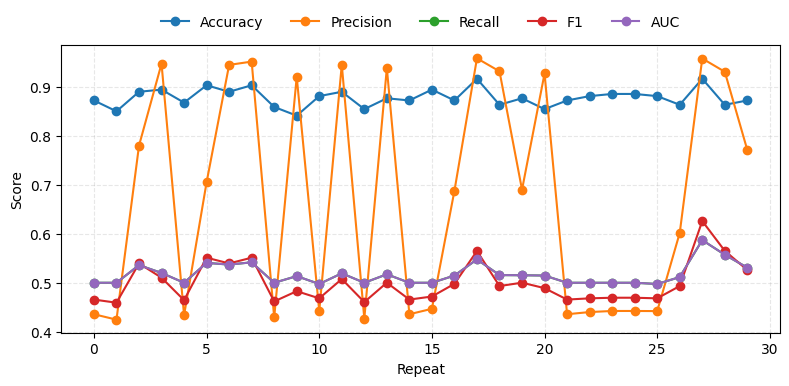

In [6]:
plot_metric_trends(f'{baseline_path}/results/{project}_RandomForest_Metrics.csv')

##### My own improvement: perform testing with the hybrid Model 

In [16]:
hybrid_metrics = []
# Load dataset for this iteration
data = pd.read_csv(f'{project}_processed_data.csv')
X_hybrid = data[text_col]
y_hybrid = data['class']

for repeated_time in range(REPEAT):
    

    X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(
        X_hybrid, y_hybrid, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    tfidf_hybrid = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_hybrid = tfidf_hybrid.fit_transform(X_train_hybrid).toarray()
    X_test_tfidf_hybrid = tfidf_hybrid.transform(X_test_hybrid).toarray()

    rf_clf_hybrid = RandomForestClassifier(n_estimators=100, max_depth=20)
    rf_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)

    logreg_clf_hybrid = LogisticRegression(max_iter=2000)
    voting_clf_hybrid = VotingClassifier(estimators=[('rf', rf_clf_hybrid), ('logreg', logreg_clf_hybrid)], voting='soft')
    voting_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)

    y_pred_hybrid = voting_clf_hybrid.predict(X_test_tfidf_hybrid)

    hybrid_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_hybrid, y_pred_hybrid),
        "Precision": precision_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "Recall": recall_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "F1": f1_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "AUC": auc(*roc_curve(y_test_hybrid, y_pred_hybrid, pos_label=1)[:2])
    })

    save_model_metrics(hybrid_metrics, f'{project}_HybridModel_Metrics.csv')


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       0.000000
Accuracy     0.871681
Precision    0.435841
Recall       0.500000
F1           0.465721
AUC          0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       0.500000
Accuracy     0.860619
Precision    0.430310
Recall       0.500000
F1           0.462526
AUC          0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       1.000000
Accuracy     0.868732
Precision    0.434366
Recall       0.500000
F1           0.464845
AUC          0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       1.500000
Accuracy     0.873894
Precision    0.436947
Recall       0.500000
F1           0.466315
AUC          0.500000
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       2.000000
Accuracy     0.872566
Precision    0.436283
Recall       0.500000
F1           0.465943
AUC          0.500000
dtype: float64


Saved: pytorch_HybridModel_Metrics.csv
Repeat       2.500000
Accuracy     0.878319
Precision    0.522458
Recall       0.503788
F1           0.474786
AUC          0.503788
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       3.000000
Accuracy     0.878635
Precision    0.510716
Recall       0.503247
F1           0.473851
AUC          0.503247
dtype: float64


Saved: pytorch_HybridModel_Metrics.csv
Repeat       3.500000
Accuracy     0.881084
Precision    0.565488
Recall       0.505445
F1           0.478753
AUC          0.505445
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       4.000000
Accuracy     0.878564
Precision    0.550345
Recall       0.504840
F1           0.476881
AUC          0.504840
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       4.500000
Accuracy     0.874336
Precision    0.537125
Recall       0.504356
F1           0.474735
AUC          0.504356
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       5.000000
Accuracy     0.875302
Precision    0.528521
Recall       0.503960
F1           0.474257
AUC          0.503960
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       5.500000
Accuracy     0.876106
Precision    0.521350
Recall       0.503630
F1           0.473860
AUC          0.503630
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       6.000000
Accuracy     0.874404
Precision    0.514092
Recall       0.503351
F1           0.472841
AUC          0.503351
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       6.500000
Accuracy     0.874210
Precision    0.508503
Recall       0.503111
F1           0.472333
AUC          0.503111
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       7.000000
Accuracy     0.874041
Precision    0.503658
Recall       0.502904
F1           0.471892
AUC          0.502904
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       7.500000
Accuracy     0.875277
Precision    0.500111
Recall       0.502723
F1           0.471896
AUC          0.502723
dtype: float64


Saved: pytorch_HybridModel_Metrics.csv
Repeat       8.000000
Accuracy     0.874805
Precision    0.496314
Recall       0.502413
F1           0.471459
AUC          0.502413
dtype: float64


Saved: pytorch_HybridModel_Metrics.csv
Repeat       8.500000
Accuracy     0.876844
Precision    0.521827
Recall       0.503602
F1           0.474277
AUC          0.503602
dtype: float64


Saved: pytorch_HybridModel_Metrics.csv
Repeat       9.000000
Accuracy     0.876106
Precision    0.543369
Recall       0.504235
F1           0.475279
AUC          0.504235
dtype: float64


Saved: pytorch_HybridModel_Metrics.csv
Repeat       9.500000
Accuracy     0.876106
Precision    0.550687
Recall       0.504789
F1           0.476523
AUC          0.504789
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       10.000000
Accuracy      0.874842
Precision     0.544691
Recall        0.504561
F1            0.475704
AUC           0.504561
dtype: float64


Saved: pytorch_HybridModel_Metrics.csv
Repeat       10.500000
Accuracy      0.874899
Precision     0.562559
Recall        0.505138
F1            0.476816
AUC           0.505138
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       11.000000
Accuracy      0.875144
Precision     0.557242
Recall        0.504914
F1            0.476443
AUC           0.504914
dtype: float64


Saved: pytorch_HybridModel_Metrics.csv
Repeat       11.500000
Accuracy      0.875737
Precision     0.573375
Recall        0.505511
F1            0.477742
AUC           0.505511
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       12.000000
Accuracy      0.876106
Precision     0.568139
Recall        0.505290
F1            0.477412
AUC           0.505290
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       12.500000
Accuracy      0.876447
Precision     0.563306
Recall        0.505087
F1            0.477107
AUC           0.505087
dtype: float64


Saved: pytorch_HybridModel_Metrics.csv
Repeat       13.000000
Accuracy      0.876270
Precision     0.577093
Recall        0.505516
F1            0.477874
AUC           0.505516
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       13.500000
Accuracy      0.877054
Precision     0.572522
Recall        0.505319
F1            0.477707
AUC           0.505319
dtype: float64




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved: pytorch_HybridModel_Metrics.csv
Repeat       14.000000
Accuracy      0.875954
Precision     0.567351
Recall        0.505135
F1            0.477028
AUC           0.505135
dtype: float64


Saved: pytorch_HybridModel_Metrics.csv
Repeat       14.500000
Accuracy      0.875811
Precision     0.579625
Recall        0.505520
F1            0.477721
AUC           0.505520
dtype: float64




##### Save results to csv file

In [17]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in hybrid_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in hybrid_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in hybrid_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in hybrid_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in hybrid_metrics])
}

save_model_metrics([final_metrics], f'{project}_HybridModel_Final_Metrics.csv')

Saved: pytorch_HybridModel_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.875811
Avg_Precision     0.579625
Avg_Recall        0.505520
Avg_F1            0.477721
Avg_AUC           0.505520
dtype: float64




##### Load results for Hybrid Model 

In [18]:
df = pd.read_csv(f'{baseline_path}/results/{project}_HybridModel_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.875811,0.579625,0.50552,0.477721,0.50552


##### Line chart repeats

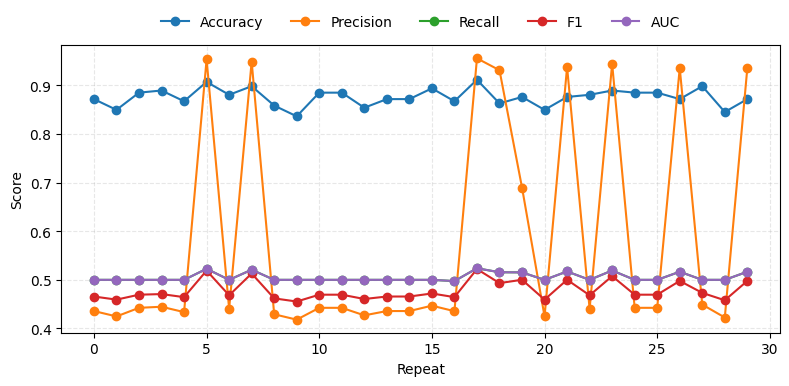

In [7]:
plot_metric_trends(f'{baseline_path}/results/{project}_HybridModel_Metrics.csv')

### Step 3: Validate results

###### Now that the training has been complete with the baselineto be able to compare with my own improvements. 
###### I want to ensure my results can be trusted so, FOR THE HYBRID MODEL, I will test on holdout data, check for data leakage an overfitting. I will also check the class distribution of the training set and perfrom SMOTE to Balance the dataset and retest witht the hybrid model, to see if there any differences in results

##### Test Hybrid Model on Holdout Data ---Shoukld this repeat 30 times???

In [19]:
###0 IS A NONBUG, SO IT IS WHAT SHOULD BE PRE4DICTED AS NONBUG

# Define function to test trained hybrid model on holdout set
def test_on_holdout_hybrid(model):
    holdout_data_hybrid = pd.read_csv(f'{project}_processed_data_holdout.csv')
    holdout_text_hybrid = holdout_data_hybrid[text_col]
    holdout_labels_hybrid = holdout_data_hybrid['class']

    tfidf_hybrid_holdout = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_holdout_hybrid = tfidf_hybrid_holdout.fit_transform(holdout_text_hybrid).toarray()

    holdout_preds_hybrid = model.predict(X_holdout_hybrid)
    print("\n🔍 Holdout Set Performance (Hybrid Model):")
    print(classification_report(holdout_labels_hybrid, holdout_preds_hybrid, target_names=['Non-Bug', 'Bug']))

    # Load full processed dataset
data = pd.read_csv(f'{project}_processed_data.csv')

# Create holdout split (90% train/test, 10% holdout)
train_test_data, holdout_data = train_test_split(data, test_size=0.1, random_state=42)

# Save to CSV for consistent usage across notebooks
train_test_data.to_csv(f'{project}_processed_train_test_data_holdout.csv', index=False)
holdout_data.to_csv(f'{project}_processed_data_holdout.csv', index=False)




hybrid_holdout_metrics = []

# Load 90% dataset for training/testing splits
data_hybrid_holdout = pd.read_csv(f'{project}_processed_train_test_data_holdout.csv')
X_hybrid_holdout = data_hybrid_holdout[text_col]
y_hybrid_holdout = data_hybrid_holdout['class']

for repeated_time in range(REPEAT):
    # Split into 70/30
    X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(
        X_hybrid_holdout, y_hybrid_holdout, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # TF-IDF
    tfidf_hybrid = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_hybrid = tfidf_hybrid.fit_transform(X_train_hybrid).toarray()
    X_test_tfidf_hybrid = tfidf_hybrid.transform(X_test_hybrid).toarray()

    # Random Forest
    rf_clf_hybrid = RandomForestClassifier(n_estimators=100, max_depth=20)
    rf_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)

    # Hybrid Model: Random Forest + Logistic Regression
    logreg_clf_hybrid = LogisticRegression(max_iter=2000)
    voting_clf_hybrid = VotingClassifier(estimators=[
        ('rf', rf_clf_hybrid), 
        ('logreg', logreg_clf_hybrid)
    ], voting='soft')
    voting_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)
    y_pred_hybrid = voting_clf_hybrid.predict(X_test_tfidf_hybrid)

    # Save metrics for each repeat
    hybrid_holdout_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_hybrid, y_pred_hybrid),
        "Precision": precision_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "Recall": recall_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "F1": f1_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "AUC": auc(*roc_curve(y_test_hybrid, y_pred_hybrid, pos_label=1)[:2])
    })

# Save all repeated metrics to CSV
#save_model_metrics(hybrid_holdout_metrics, f'{project}_HybridModel_Holdout_Metrics.csv')



# Evaluate on true holdout portion
test_on_holdout_hybrid(voting_clf_hybrid)


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: Unde


🔍 Holdout Set Performance (Hybrid Model):
              precision    recall  f1-score   support

     Non-Bug       0.87      1.00      0.93        66
         Bug       0.00      0.00      0.00        10

    accuracy                           0.87        76
   macro avg       0.43      0.50      0.46        76
weighted avg       0.75      0.87      0.81        76



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: Unde

##### Save results to csv file

In [20]:
## Save results here

##### Load results for test on holdout

In [21]:
#df = pd.read_csv("processed_data_holdout.csv")
#df.head() 

##### Check for data leakage and overfitting

In [22]:
#check where these variables are coming from
check_data_leakage(X_train_tfidf_hybrid, X_test_tfidf_hybrid)
check_overfitting(voting_clf_hybrid, X_train_tfidf_hybrid, y_train_hybrid, X_test_tfidf_hybrid, y_test_hybrid)


🔍 Checking Data Leakage...
⚠️ 2 samples from test data are also in training data.
❌ Data Leakage Detected! Test data should not exist in training set.

🔍 Checking Overfitting...
📊 Training Accuracy: 0.9239
📊 Test Accuracy: 0.8867
✅ No significant overfitting detected.


##### Check class distribution 

In [23]:
print("\nClass Distribution in Training Set:")
print(y_train_hybrid.value_counts())
print("\nClassification Report:")
print(classification_report(y_test_hybrid, y_pred_hybrid))


Class Distribution in Training Set:
class
0    411
1     62
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       180
           1       0.00      0.00      0.00        23

    accuracy                           0.89       203
   macro avg       0.44      0.50      0.47       203
weighted avg       0.79      0.89      0.83       203



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Perform Smote to Balance Dataset and Test Hybrid Model 

In [24]:
smote_hybrid_metrics = []

# Load dataset for SMOTE-based training
data_smote_hybrid = pd.read_csv(f'{project}_processed_data.csv')
X_smote_hybrid = data_smote_hybrid[text_col]
y_smote_hybrid = data_smote_hybrid['class']

for repeated_time in range(REPEAT):
    # Train-test split (70/30)
    X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
        X_smote_hybrid, y_smote_hybrid, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # TF-IDF vectorization
    tfidf_smote = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_smote = tfidf_smote.fit_transform(X_train_smote).toarray()
    X_test_tfidf_smote = tfidf_smote.transform(X_test_smote).toarray()

    # Train Hybrid Model
    rf_clf_smote = RandomForestClassifier(n_estimators=100, max_depth=20)
    logreg_clf_smote = LogisticRegression(max_iter=2000)
    hybrid_clf_smote = VotingClassifier(
        estimators=[('rf', rf_clf_smote), ('logreg', logreg_clf_smote)],
        voting='soft'
    )

    # Apply SMOTE to balance training data
    smote = SMOTE()
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf_smote, y_train_smote)

    # Train on balanced data
    hybrid_clf_smote.fit(X_train_balanced, y_train_balanced)

    # Predict on original (unbalanced) test set
    y_pred_smote_hybrid = hybrid_clf_smote.predict(X_test_tfidf_smote)

    # Collect metrics
    smote_hybrid_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_smote, y_pred_smote_hybrid),
        "Precision": precision_score(y_test_smote, y_pred_smote_hybrid, average='macro'),
        "Recall": recall_score(y_test_smote, y_pred_smote_hybrid, average='macro'),
        "F1": f1_score(y_test_smote, y_pred_smote_hybrid, average='macro'),
        "AUC": auc(*roc_curve(y_test_smote, y_pred_smote_hybrid, pos_label=1)[:2])
    })

# Save metrics after all repeats
save_model_metrics(smote_hybrid_metrics, f'{project}_SMOTE_HybridModel_Metrics.csv')


Saved: pytorch_SMOTE_HybridModel_Metrics.csv
Repeat       14.500000
Accuracy      0.880383
Precision     0.725388
Recall        0.686121
F1            0.699551
AUC           0.686121
dtype: float64




##### Save and load results

In [25]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in smote_hybrid_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in smote_hybrid_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in smote_hybrid_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in smote_hybrid_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in smote_hybrid_metrics])
}

save_model_metrics([final_metrics], f'{project}_SMOTE_HybridModel_Final_Metrics.csv')

Saved: pytorch_SMOTE_HybridModel_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.880383
Avg_Precision     0.725388
Avg_Recall        0.686121
Avg_F1            0.699551
Avg_AUC           0.686121
dtype: float64




In [26]:
df = pd.read_csv(f'{baseline_path}/results/{project}_SMOTE_HybridModel_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.880383,0.725388,0.686121,0.699551,0.686121


In [27]:
# ✅ Data Leakage Check (only makes sense for original training data before SMOTE)
check_data_leakage(X_train_tfidf_smote, X_test_tfidf_smote)

# ✅ Overfitting Check (use SMOTE-balanced training data and unbalanced test data)
check_overfitting(hybrid_clf_smote, X_train_balanced, y_train_balanced, X_test_tfidf_smote, y_test_smote)

# ✅ Class Distribution
print("\nOriginal Class Distribution in Training Set (Before SMOTE):")
print(y_train_smote.value_counts())

print("\nBalanced Class Distribution After SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# ✅ Classification Report
print("\nClassification Report (SMOTE Hybrid Model):")
print(classification_report(y_test_smote, y_pred_smote_hybrid))


🔍 Checking Data Leakage...
⚠️ 1 samples from test data are also in training data.
❌ Data Leakage Detected! Test data should not exist in training set.

🔍 Checking Overfitting...
📊 Training Accuracy: 0.9967
📊 Test Accuracy: 0.8496
❌ Possible Overfitting: Model performs much better on training data.

Original Class Distribution in Training Set (Before SMOTE):
class
0    461
1     65
Name: count, dtype: int64

Balanced Class Distribution After SMOTE:
class
0    461
1    461
Name: count, dtype: int64

Classification Report (SMOTE Hybrid Model):
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       196
           1       0.42      0.33      0.37        30

    accuracy                           0.85       226
   macro avg       0.66      0.63      0.64       226
weighted avg       0.84      0.85      0.84       226

